In [1]:
import os
from argparse import ArgumentParser
from collections import OrderedDict

from tqdm.notebook import  tqdm

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
import torchvision.transforms.functional as TF
from torch.utils.data import Dataset, DataLoader, random_split

import pytorch_lightning as pl

from PIL import Image

from glob import glob

# Data Set augmentation and Dataset class

In [2]:
# Random Crop Augment
class RandomCrop():
    def __init__(self, min_crop = 256, max_crop = 1024):
        self.min_crop = min_crop
        self.max_crop = max_crop
    
    @staticmethod
    def random_crop(I1, crop_size):
        h, w = I1.size # Assume I1.size == I2.size
        th, tw = crop_size
        
        if w == tw and h == th:
            return 0, 0, h, w

        i = torch.randint(0, h - th + 1, size=(1, )).item()
        j = torch.randint(0, w - tw + 1, size=(1, )).item()
        return i, j, i+th, j+tw
    
    def __call__(self, img_set):
        I1, I2 = img_set
        cs = torch.randint(self.min_crop, self.max_crop, size=(1, )).item()
        crop_size = (cs, cs)
        bbox =  self.random_crop(I1, crop_size)
        
        return I1.crop(bbox), I2.crop(bbox)
    
class RandomRotate():
    def __init__(self, min_angle = -25, max_angle = 25):
        self.min_angle = min_angle
        self.max_angle = max_angle
    
    def __call__(self, img_set):
        I1, I2 = img_set
        angle = torch.randint(self.min_angle, self.max_angle, size=(1, )).item()
        return TF.rotate(I1, angle, Image.BILINEAR), TF.rotate(I2, angle, Image.BILINEAR)

class RandomFlip():
    def __init__(self):
        pass
    
    def __call__(self, img_set):
        I1, I2 = img_set
        horizontal_flip = np.random.choice([True, False])
        vertical_flip = np.random.choice([True, False])
        if horizontal_flip:
            I1 = I1.transpose(Image.FLIP_LEFT_RIGHT)
            I2 = I2.transpose(Image.FLIP_LEFT_RIGHT)
        if vertical_flip:
            I1 = I1.transpose(Image.FLIP_TOP_BOTTOM)
            I2 = I2.transpose(Image.FLIP_TOP_BOTTOM)
        
        return I1, I2

class ColorJitter():
    def __init__(self, brightness=0, contrast=0, saturation=0, hue=0):
        self.color_jitter = transforms.ColorJitter(brightness, contrast, saturation, hue)
    
    def __call__(self, img_set):
        I1, I2 = img_set
        
        return self.color_jitter(I1), I2

class CenterCrop():
    def __init__(self, crop):
        self.center_crop = transforms.CenterCrop(crop)
    
    def __call__(self, img_set):
        I1, I2 = img_set
        return self.center_crop(I1), self.center_crop(I2)
    

class Resize():
    def __init__(self, size):
        self.resize = transforms.Resize(size)
    
    def __call__(self, img_set):
        I1, I2 = img_set
        return self.resize(I1), self.resize(I2)
    
class ToTensor():
    def __init__(self):
        self.tensor = transforms.ToTensor()
    
    def __call__(self, img_set):
        I1, I2 = img_set
        return self.tensor(I1), self.tensor(I2)
    

class Normalize():
    def __init__(self, mean = (0.5,0.5, 0.5), std = (0.5,0.5, 0.5)):
        self.norm = transforms.Normalize(mean, std)
    
    def __call__(self, img_set):
        I1, I2 = img_set
        return self.norm(I1), self.norm(I2)

data_transform = transforms.Compose([
#     RandomCrop(min_crop = 128, max_crop = 1024),
#     Resize(160),
#     RandomRotate(min_angle = -25, max_angle = 25),
#     CenterCrop(128),
#     ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.5),
#     RandomFlip(),
    ToTensor(),
    Normalize((0.5,0.5, 0.5), (0.5,0.5, 0.5))
])
    
class TextureDataset(Dataset):
    def __init__(self, imgs, img_size = 128, transform = data_transform):

        self.imgs = imgs
        self.img_size = img_size
        self.num_samples = len(self.imgs)
        self.transform = transform

    def __getitem__(self, i):

        I = Image.open(self.imgs[i]).convert("RGB")
        I_diffuse = I.crop((0, 0, self.img_size, self.img_size)) 
        I_normal = I.crop((self.img_size, 0, self.img_size*2, self.img_size)) 
        if self.transform:
            I_diffuse, I_normal = self.transform([I_diffuse, I_normal])
        return I_diffuse, I_normal

    def __len__(self):
        return self.num_samples

src_fldr = r"G:\texture\data_1"
aug_data = r"G:\texture\augmented_data"

imgs = glob(src_fldr + os.sep + "*.png")
texture_dataset = TextureDataset(imgs)

c = 0
for i in tqdm(range(len(imgs))):
    I = Image.open(imgs[i]).convert("RGB")
    I_diffuse = I.crop((0, 0, 1024, 1024)) 
    I_normal = I.crop((1024, 0, 2048, 1024)) 
    for j in range(100):
        I_diffuse_1, I_normal_1 = data_transform([I_diffuse, I_normal])
        I_1 = np.concatenate([np.uint8(I_diffuse_1).copy(), np.uint8(I_normal_1).copy()], axis = 1)
        Image.fromarray(I_1).save(aug_data + os.sep + "{0:04d}.png".format(c))
        c += 1

In [3]:
class TextureLightDataModule(pl.LightningDataModule):

    def __init__(self, data_fldr: str = '', data_ext: str = '.png', batch_size: int = 64, train_val_split:float = 0.9, num_workers: int = 0):
        super().__init__()
        self.data_fldr = data_fldr
        self.data_ext = data_ext
        self.batch_size = batch_size
        self.train_val_split = train_val_split
        self.num_workers = num_workers
        
    def prepare_data(self):
        self.imgs = glob(self.data_fldr + os.sep + "*" + self.data_ext)
        self.num_imgs = len(self.imgs)

    def setup(self, stage_name):
        np.random.shuffle(self.imgs)
        
        self.prepare_data()
        
        self.train_dataset = TextureDataset(self.imgs)
        
    def train_dataloader(self):
        return DataLoader(self.train_dataset, batch_size=self.batch_size, num_workers=self.num_workers, shuffle=True)

In [4]:
class Reshape(nn.Module):
    def __init__(self, reshape = [6, 128, 128]):
        super().__init__()
        self.reshape = reshape
    
    def forward(self, z):
        return z.view(z.size(0), *self.reshape)

class InputNoiseLayer(nn.Module):
    def __init__(self, noise_size, channel, size):
        super().__init__()

        self.init = nn.Sequential(
            nn.ConvTranspose2d(noise_size, channel, 4, 1, 0, bias=False),
            nn.BatchNorm2d(channel), 
            nn.SiLU(True) 
        )

    def forward(self, z):
        return self.init(z)
        
    
class Generator(nn.Module):
    def __init__(self, noise_size):
        super().__init__()
        self.noise_size = noise_size
        
        self.model = nn.Sequential(
            InputNoiseLayer(noise_size, 512, 4),
            *self.conv_block(in_ch = 512, out_ch = 512, ker = 3, stride = 1),
            *self.conv_block(in_ch = 512, out_ch = 256, ker = 3, stride = 1),
            nn.Upsample(scale_factor = 2), # 8x8
            *self.conv_block(in_ch = 256, out_ch = 256, ker = 3, stride = 1),
            *self.conv_block(in_ch = 256, out_ch = 256, ker = 3, stride = 1),
            *self.conv_block(in_ch = 256, out_ch = 128, ker = 3, stride = 1),
            nn.Upsample(scale_factor = 2), # 16x16
            *self.conv_block(in_ch = 128, out_ch = 128, ker = 3, stride = 1),
            *self.conv_block(in_ch = 128, out_ch = 128, ker = 3, stride = 1),
            *self.conv_block(in_ch = 128, out_ch = 64, ker = 3, stride = 1),
            nn.Upsample(scale_factor = 2), # 32x32
            *self.conv_block(in_ch = 64, out_ch = 64, ker = 3, stride = 1),
            *self.conv_block(in_ch = 64, out_ch = 64, ker = 3, stride = 1),
            *self.conv_block(in_ch = 64, out_ch = 32, ker = 3, stride = 1),
            nn.Upsample(scale_factor = 2), # 64x64
            *self.conv_block(in_ch = 32, out_ch = 32, ker = 3, stride = 1),
            *self.conv_block(in_ch = 32, out_ch = 32, ker = 3, stride = 1),
            nn.Upsample(scale_factor = 2), # 128x128
            *self.conv_block(in_ch = 32, out_ch = 32, ker = 3, stride = 1),
            *self.conv_block(in_ch = 32, out_ch = 32, ker = 3, stride = 1),
            nn.Conv2d(in_channels=32, out_channels=3, kernel_size=1),
            nn.Hardtanh()
        )
    
    @staticmethod
    def conv_block(in_ch = 3, out_ch = 32, ker = 3, stride = 1, groups = 1):

        layers = []
        pad = ker//2 if ker > 1 else 0
        if pad > 0:
            layers = [nn.ReflectionPad2d(pad)]
        layers += [nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=ker, padding = 0, bias=True, stride = stride, groups = groups),
                   nn.BatchNorm2d(out_ch),
                   nn.SiLU(True),
                   ]

        return layers        
    
    def forward(self, z):
        return self.model(z)

In [5]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()
        
        self.feat_1 = nn.Sequential(
            *self.conv_block(in_ch = 3, out_ch = 32, ker = 3, stride = 2), # 64x64
            *self.conv_block(in_ch = 32, out_ch = 64, ker = 3, stride = 2), # 32x32
        )
        
        self.feat_2 = nn.Sequential(
            *self.conv_block(in_ch = 64, out_ch = 128, ker = 3, stride = 2), # 16x16
            *self.conv_block(in_ch = 128, out_ch = 128, ker = 3, stride = 2), # 8x8
        )
        
        self.pred = nn.Sequential(
            *self.conv_block(in_ch = 128, out_ch = 256, ker = 3, stride = 2), # 4x4
            nn.Dropout(0.25),
            nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1),
            nn.Flatten()
        )
        
        self.recon_1 = nn.Sequential(
            nn.Conv2d(in_channels=64, out_channels=3, kernel_size=1),
            nn.Hardtanh()
        )
        
        self.recon_2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=3, kernel_size=1),
            nn.Hardtanh()
        )
        
#         self.model = nn.Sequential(
#             *self.conv_block(in_ch = 3, out_ch = 32, ker = 3, stride = 2), # 64x64
#             *self.conv_block(in_ch = 32, out_ch = 64, ker = 3, stride = 2), # 32x32
#             *self.conv_block(in_ch = 64, out_ch = 128, ker = 3, stride = 2), # 16x16
#             *self.conv_block(in_ch = 128, out_ch = 128, ker = 3, stride = 2), # 8x8
#             *self.conv_block(in_ch = 128, out_ch = 256, ker = 3, stride = 2), # 4x4
#             nn.Dropout(0.25),
#             nn.Conv2d(in_channels=256, out_channels=1, kernel_size=1),
#             nn.Flatten()
#         )
    
    @staticmethod
    def conv_block(in_ch = 3, out_ch = 32, ker = 3, stride = 1, groups = 1):

        layers = []
        pad = ker//2 if ker > 1 else 0
        if pad > 0:
            layers = [nn.ReflectionPad2d(pad)]
        layers += [nn.utils.spectral_norm(nn.Conv2d(in_channels=in_ch, out_channels=out_ch, kernel_size=ker, padding = 0, bias=True, stride = stride, groups = groups)),
                   nn.BatchNorm2d(out_ch),
                   nn.LeakyReLU(0.1, True),
                   ]

        return layers
        
    def forward(self, I):
        
        feat_1 = self.feat_1(I)
        feat_2 = self.feat_2(feat_1)
        
        I_32x32 = self.recon_1(feat_1)
        I_8x8 = self.recon_2(feat_2)
        
        pred = self.pred(feat_2)
        
        return pred, I_32x32, I_8x8

In [6]:
def weights_init(m):
    classname = m.__class__.__name__
    if classname.find('Conv') != -1:
        try:
            m.weight.data.normal_(0.0, 0.02)
        except:
            pass
    elif classname.find('BatchNorm') != -1:
        m.weight.data.normal_(1.0, 0.02)
        m.bias.data.fill_(0)
        
class GAN(pl.LightningModule):

    def __init__(
        self,
        channels,
        width,
        height,
        latent_dim: int = 64,
        lr: float = 0.0002,
        b1: float = 0.5,
        b2: float = 0.999,
        batch_size: int = 32,
        **kwargs
    ):
        super().__init__()
        self.save_hyperparameters()

        # networks
        data_shape = [channels, width, height]
        self.generator = Generator(noise_size=self.hparams.latent_dim)
        self.discriminator = Discriminator()
        
        self.generator.apply(weights_init)
        self.discriminator.apply(weights_init)

        self.validation_z = torch.randn(2, self.hparams.latent_dim, 1, 1)

        self.example_input_array = torch.zeros(2, self.hparams.latent_dim, 1, 1)
        
        self.epoch_end_count = 0

    def forward(self, z):
        return self.generator(z)

    def training_step(self, batch, batch_idx, optimizer_idx):
        imgs, imgs_normal = batch#_diffuse
#         imgs = torch.cat([imgs_diffuse, imgs_normal], dim = 1)

        # sample noise
        z = torch.randn(imgs.shape[0], self.hparams.latent_dim, 1, 1)
        z = z.type_as(imgs)
        # train generator
        if optimizer_idx == 0:

            # generate images
            self.generated_imgs = self(z)

            # adversarial loss
            g_loss, _, _ = self.discriminator(self.generated_imgs)
            g_loss = - g_loss.mean()
            
            self.log('g_loss', g_loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
            return g_loss

        # train discriminator
        if optimizer_idx == 1:
            # Measure discriminator's ability to classify real from generated samples

            real_pred, real_I_32x32, real_I_8x8 = self.discriminator(imgs)
            real_disc_loss = torch.nn.ReLU()(torch.rand_like(real_pred) * 0.2 + 0.8  - real_pred).mean()
            recon_loss_32x32 = nn.functional.l1_loss(real_I_32x32, nn.functional.interpolate(imgs, size = (32, 32), mode = "bilinear", align_corners=False))
            recon_loss_8x8 = nn.functional.l1_loss(real_I_8x8, nn.functional.interpolate(imgs, size = (8, 8), mode = "bilinear", align_corners=False))
            recon_loss = 10 * (recon_loss_32x32 + recon_loss_8x8)
            real_loss = real_disc_loss + recon_loss

            fake_pred, _, _ = self.discriminator(self(z).detach())
            fake_loss = torch.nn.ReLU()(torch.rand_like(fake_pred) * 0.2 + 0.8  + fake_pred).mean()

            # discriminator loss is the average of these
            d_loss = real_loss + fake_loss
            
            self.log('d_loss', d_loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
            self.log('recon_loss', recon_loss, on_step=True, on_epoch=False, prog_bar=True, logger=True)
            return d_loss

    def configure_optimizers(self):
        lr = self.hparams.lr
        b1 = self.hparams.b1
        b2 = self.hparams.b2

        opt_g = torch.optim.Adam(self.generator.parameters(), lr=lr, betas=(b1, b2))
        opt_d = torch.optim.Adam(self.discriminator.parameters(), lr=lr, betas=(b1, b2))
        return [opt_g, opt_d], []

    def on_epoch_end(self):
        z = self.validation_z.type_as(self.generated_imgs)

        # log sampled images
        sample_imgs = self(z).detach() + 1.0
#         sample_imgs = torch.cat([sample_imgs[:, :3, :, :], sample_imgs[:, 3:, :, :]], dim = 3)+1.0
        grid = torchvision.utils.make_grid(sample_imgs/2.0)
        self.logger.experiment.add_image('generated_images', grid, self.epoch_end_count)
        self.epoch_end_count += 1
        

In [7]:
data_fldr = r"G:\texture\augmented_data"
root_dir = r"E:\SP_2021\synthTEX_logging"
exp_name = "model_exp_01"
batch_size = 8

In [8]:
dm = TextureLightDataModule(data_fldr, batch_size = batch_size)
model = GAN(3, 128, 128, batch_size = batch_size)
trainer = pl.Trainer(gpus=1, max_epochs=1000, progress_bar_refresh_rate=1, default_root_dir = root_dir + os.sep + exp_name)
trainer.fit(model, dm)

GPU available: True, used: True
TPU available: None, using: 0 TPU cores
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name          | Type          | Params | In sizes      | Out sizes       
-----------------------------------------------------------------------------------
0 | generator     | Generator     | 6.0 M  | [2, 64, 1, 1] | [2, 3, 128, 128]
1 | discriminator | Discriminator | 538 K  | ?             | ?               
-----------------------------------------------------------------------------------
6.6 M     Trainable params
0         Non-trainable params
6.6 M     Total params


C:\Users\narsi\anaconda3\lib\site-packages\pytorch_lightning\utilities\distributed.py:49: UserWarning: Detected KeyboardInterrupt, attempting graceful shutdown...
  warnings.warn(*args, **kwargs)


1

In [15]:
model = GAN.load_from_checkpoint(r"E:\SP_2021\synthTEX_logging\model_exp_01\lightning_logs\version_0\checkpoints\epoch=16-step=89231.ckpt", channels = 3, width = 128, height = 128, batch_size = batch_size)

In [48]:
z = torch.clamp(torch.randn(64, 3, 64, 1, 1), -1, 1).mean(dim = 1)
I = model.generator(z)
I = (I + 1)/2.0
grid = torchvision.utils.make_grid(I).data.cpu().numpy()
grid = np.uint8(grid * 255.0).transpose(1, 2, 0)

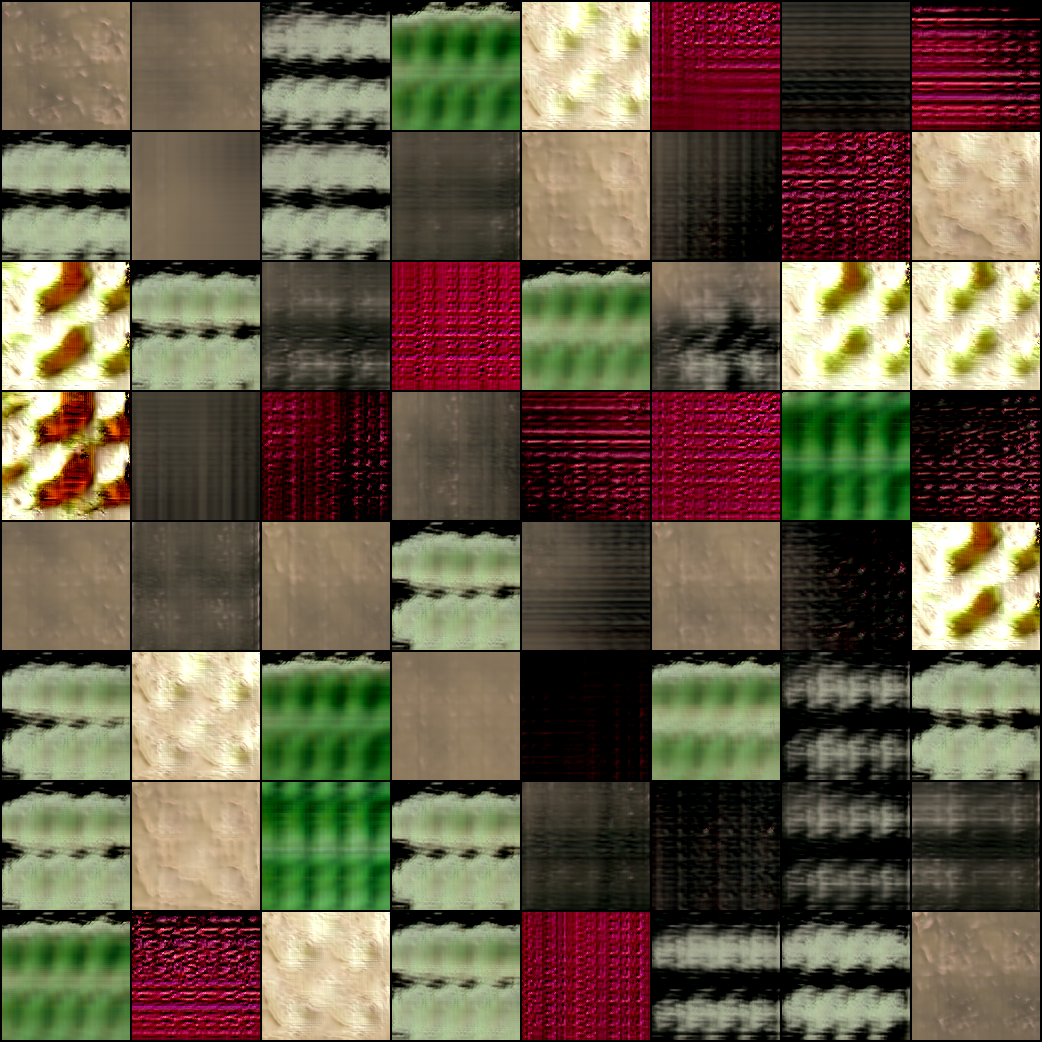

In [49]:
Image.fromarray(grid)